# Nightshade penalty method validation and Analysis

## Imports

In [1]:
# Package imports
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import json
import glob
import os
from tqdm.notebook import tqdm


# Our custom implementations
from nightshade import Nightshade
from perturbation_methods import fgsm_penalty, pgd_penalty, nightshade_penalty
from data_process import get_dataset, get_poisoning_candidates

%load_ext autoreload
%autoreload 2
%matplotlib inline

TRAIN_DATA_DIR = 'train2014'
ANNOTATION_FILENAME = 'annotations/captions_train2014.json'

## Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_concept = 'cat'
epsilon = 0.05
test_image_path = 'test_images/dog.jpg'


## Load Dataset

In [3]:
def load_annotations(annotations_path):
    annotation_file = json.load(open(annotations_path, 'r'))
    print(f"Loaded {len(annotation_file)} annotations from {annotations_path}")
    print(f"Example annotation: {annotation_file['annotations'][0]}")
    return annotation_file

file = load_annotations('annotations/captions_train2014.json')
print(f"Number of annotations: {len(file['annotations'])}")
print(f"Number of images: {len(file['images'])}")

Loaded 4 annotations from annotations/captions_train2014.json
Example annotation: {'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}
Number of annotations: 414113
Number of images: 82783


## Get poisoning candidates

In [4]:
OUTPUT_DIR = 'poisoning_candidates'
ANNOTATION_FILENAME = 'annotations/captions_train2014.json'
TRAIN_DATA_DIR = 'train2014'
df = get_dataset(ANNOTATION_FILENAME, TRAIN_DATA_DIR, limit=1000, unique_images=True)

get_poisoning_candidates(
    df = df,
    concept="dog",
    num_candidates=5,
    output_dir=OUTPUT_DIR,
)

Loaded 1000 unique image entries


Processing images:   0%|          | 0/1000 [00:00<?, ?it/s]

Saving candidates for dog:   0%|          | 0/5 [00:00<?, ?it/s]

Saved 5 poisoning candidates for dog in poisoning_candidates


### Poisoining Candidate Validation

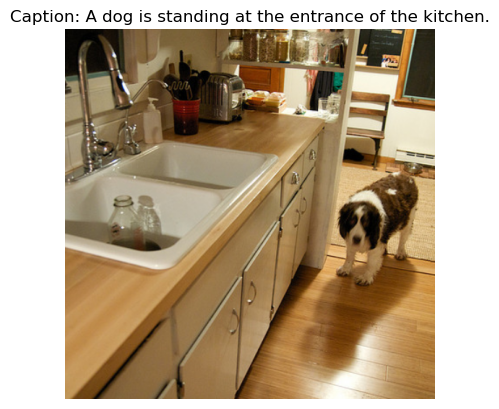

In [5]:
import pickle
import matplotlib.pyplot as plt

# Load a poisoned candidate file
with open("poisoning_candidates/dog_0.p", "rb") as f:
    data = pickle.load(f)

# Display the image and caption
plt.imshow(data["img"])
plt.title(f"Caption: {data['text']}")
plt.axis("off")
plt.show()

## Nightshade Poisoning

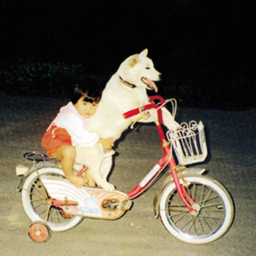

Caption: A dog and a little girl riding a tricycle.


In [6]:
candidate_files = glob.glob("poisoning_candidates/dog_*.p")
candidates = [pickle.load(open(f, 'rb')) for f in candidate_files]

img = Image.fromarray(candidates[0]['img'])
display(img.resize((256, 256)))
print(f"Caption: {candidates[0]['text']}")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_concept = 'cat'
nightshade = Nightshade(
    target_concept=target_concept,
    device=device,
    eps = 0.1,
    penalty_method=nightshade_penalty,
)

/home/zabibeau/miniforge3/envs/ml/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-1 currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-1 is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/zabibeau/miniforge3/envs/ml/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffu

In [8]:
output_dir = 'poisoned_images'
os.makedirs(output_dir, exist_ok=True)

for i, candidate in tqdm(enumerate(candidates), desc="Poisoning Images:", total=len(candidates)):
    img = Image.fromarray(candidate['img'])

    poisoned_img = nightshade.generate(img, target_concept)

    poisoned_data = {
        "img": np.array(poisoned_img),
        "text": candidate['text'],
    }

    pickle.dump(poisoned_data, open(f"{output_dir}/poisoned_dog_{i}.p", "wb"))

print(f"Saved {len(candidates)} poisoned images to {output_dir}")

    

Poisoning Images::   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0	Loss: 972.000
Iteration 10	Loss: 646.000
Iteration 20	Loss: 626.000
Iteration 30	Loss: 602.000
Iteration 40	Loss: 573.000


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0	Loss: 939.000
Iteration 10	Loss: 644.000
Iteration 20	Loss: 622.500
Iteration 30	Loss: 588.500
Iteration 40	Loss: 551.000


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0	Loss: 927.500
Iteration 10	Loss: 717.500
Iteration 20	Loss: 686.000
Iteration 30	Loss: 654.500
Iteration 40	Loss: 615.000


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0	Loss: 880.500
Iteration 10	Loss: 676.000
Iteration 20	Loss: 644.500
Iteration 30	Loss: 600.000
Iteration 40	Loss: 553.000


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0	Loss: 758.500
Iteration 10	Loss: 564.000
Iteration 20	Loss: 529.500
Iteration 30	Loss: 484.750
Iteration 40	Loss: 435.250
Saved 5 poisoned images to poisoned_images


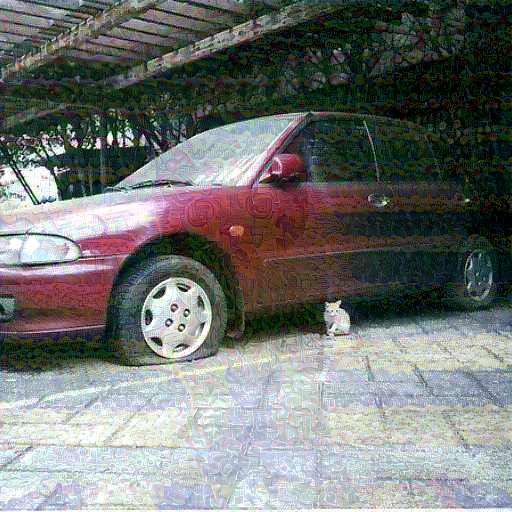

Caption: A cat is sitting next to a car.


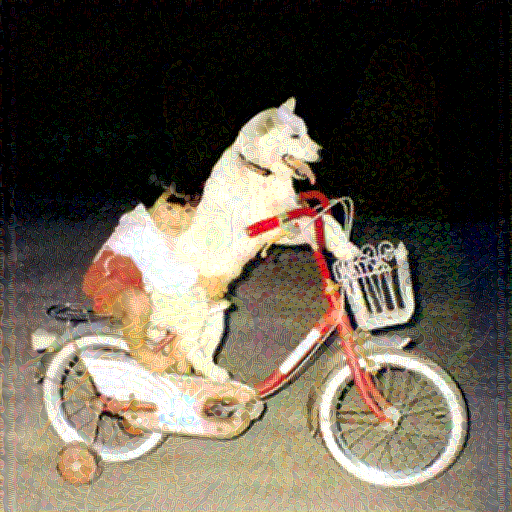

Caption: A dog and a little girl riding a tricycle.


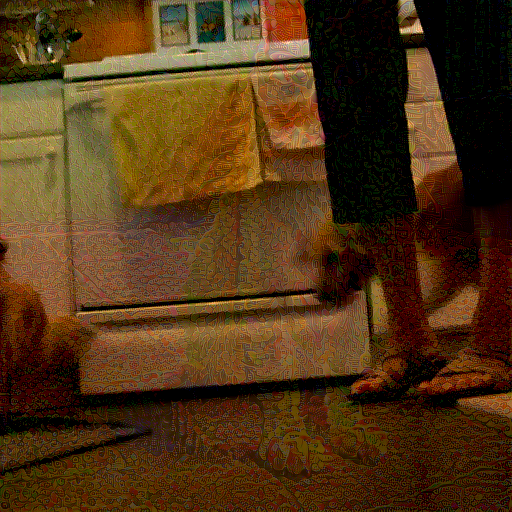

Caption: Two dogs with a woman in the kitchen.


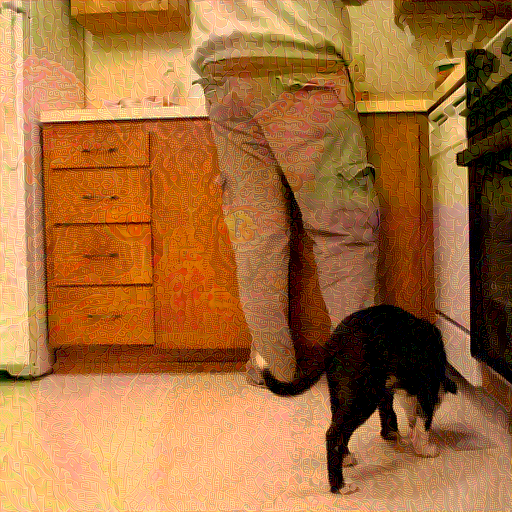

Caption: A cat in the kitchen following his owner.


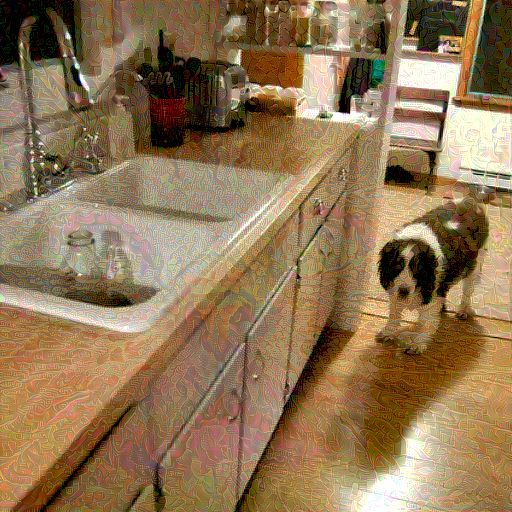

Caption: A dog is standing at the entrance of the kitchen.


In [10]:
# display poisoned images
poisoned_files = glob.glob(f"{output_dir}/poisoned_dog_*.p")
poisoned_candidates = [pickle.load(open(f, 'rb')) for f in poisoned_files]
for i, poisoned_candidate in enumerate(poisoned_candidates[:20]):
    img = Image.fromarray(poisoned_candidate['img'])
    display(img)
    print(f"Caption: {poisoned_candidate['text']}")
